Conversion rate Project

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
#Chargement de données
data = pd.read_csv('conversion_data_train.csv')

In [3]:
data.shape

(284580, 6)

In [4]:
df_sample = data.sample(150000)

In [5]:
#df=df_sample.copy()
df=data.copy()

In [6]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [7]:
#quelques statistiques basiques
df.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


La moyenne d'age est 30 ans, avec un ecart type faible ce qui indquie que les differents ages sont proches de la moyennen, mais comme il existe des valeur aberantes telle que 123 ans et qui ont une inflence sur la moyenne, je vais nettoyer le dataset en supprimant les valeurs aberantes.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


Il n'existe pas de valeurs nulles.

In [9]:
df.shape

(284580, 6)

<Axes: xlabel='source', ylabel='count'>

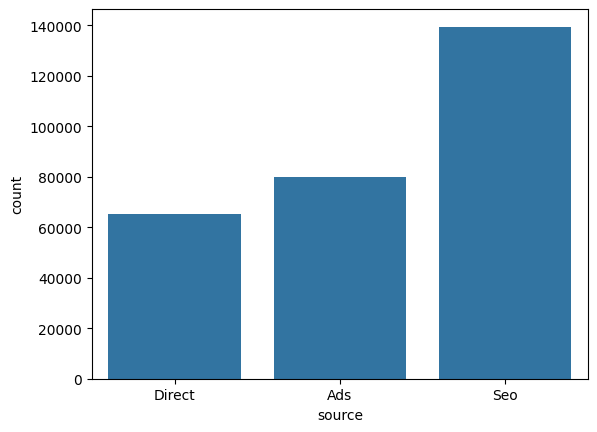

In [10]:
sns.countplot(x='source', data=df)

<Axes: xlabel='country', ylabel='count'>

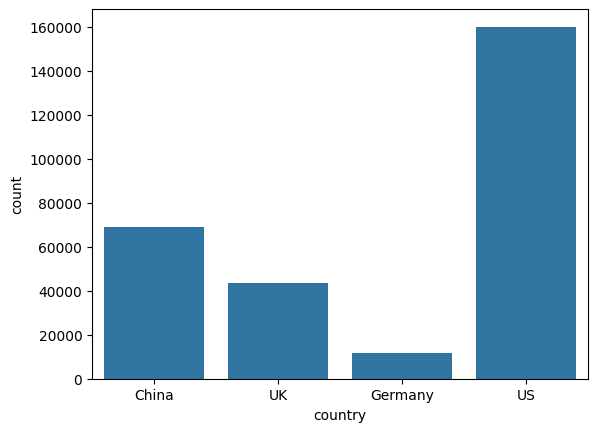

In [11]:
sns.countplot(x='country', data=df)

<Axes: xlabel='new_user', ylabel='count'>

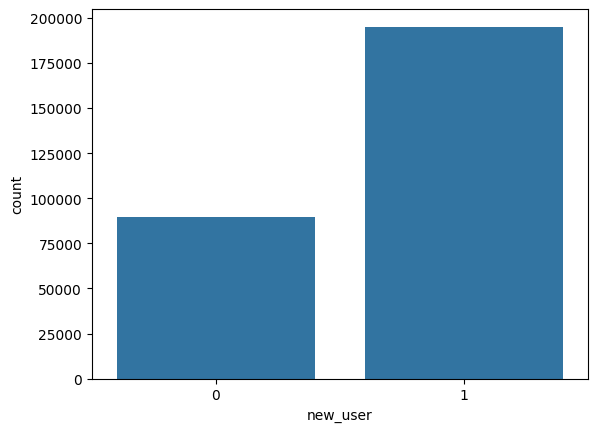

In [12]:
sns.countplot(x="new_user", data=df)

<Axes: xlabel='converted', ylabel='count'>

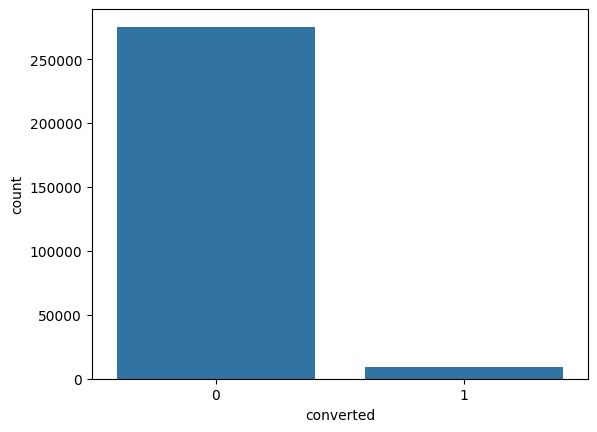

In [13]:
sns.countplot(x="converted", data=df)

Je constate que 0 est largement plus representé, ce qui nous met dans un cas d'un dataset desiquilibré.

<Axes: xlabel='age', ylabel='Count'>

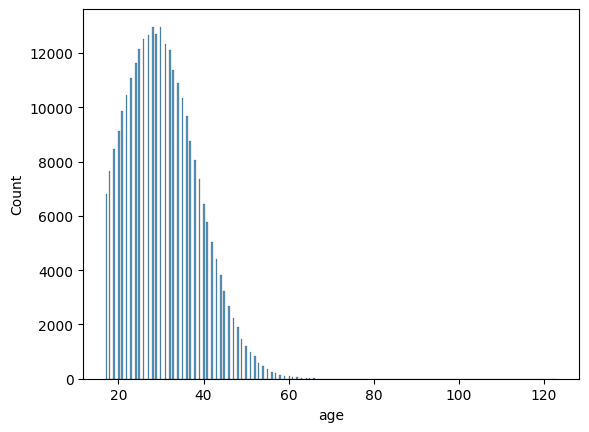

In [14]:
sns.histplot(data=df, x="age")

<Axes: ylabel='age'>

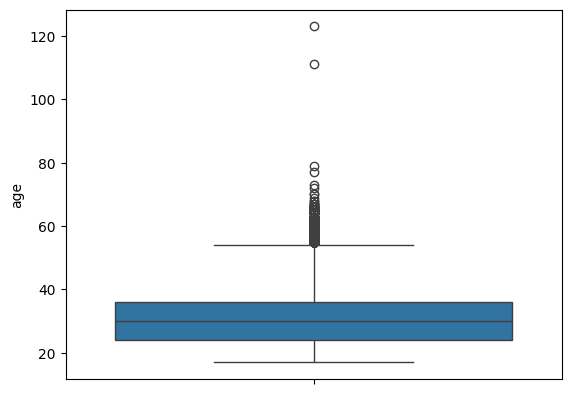

In [15]:
sns.boxplot(df['age'])

D'après ce boxplot les valeurs supérieurs à 75 ans sont aberantes.

In [16]:
# Calcul du pourcentage d'individus ayant un âge supérieur à 75
percentage_over_75 = (df["age"] > 75).sum() / df["age"].shape[0] * 100

# Affichage du pourcentage
print(f"Pourcentage d'individus ayant un âge supérieur à 75 : {percentage_over_75:.4f}%")

Pourcentage d'individus ayant un âge supérieur à 75 : 0.0014%


<Axes: xlabel='age', ylabel='Count'>

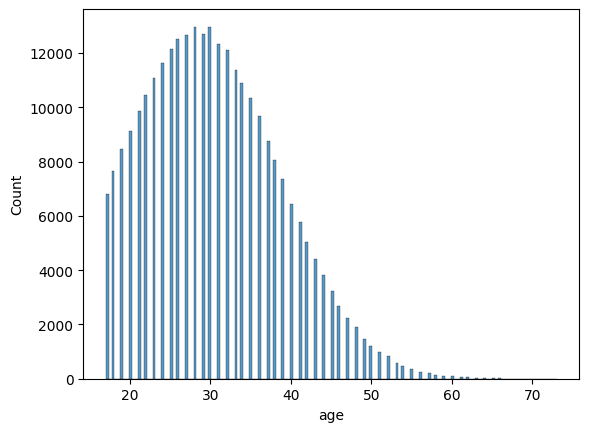

In [17]:
df1=df[df["age"]<75]
sns.histplot(data=df1, x="age")

In [18]:
df1.describe()

,age,new_user,total_pages_visited,converted
count,284576.000000,284576.000000,284576.000000,284576.000000
mean,30.563263,0.685458,4.873215,0.032251
std,8.262698,0.464334,3.341942,0.176668
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,73.000000,1.000000,29.000000,1.000000


<Axes: xlabel='total_pages_visited', ylabel='Count'>

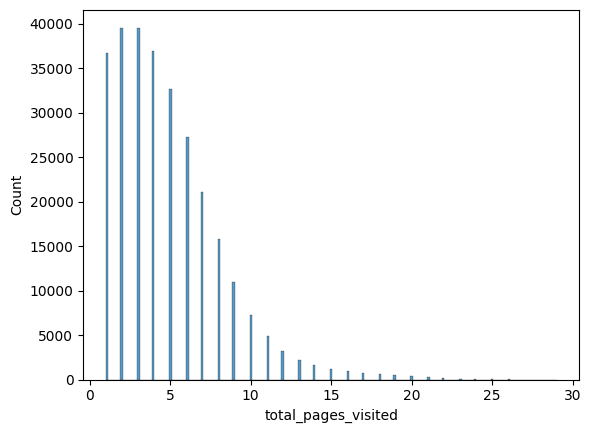

In [19]:
sns.histplot(data=df1, x="total_pages_visited")

In [20]:
px.box(df1, y = 'age', color = 'country', title = 'Ages per country',width=900, height=600)

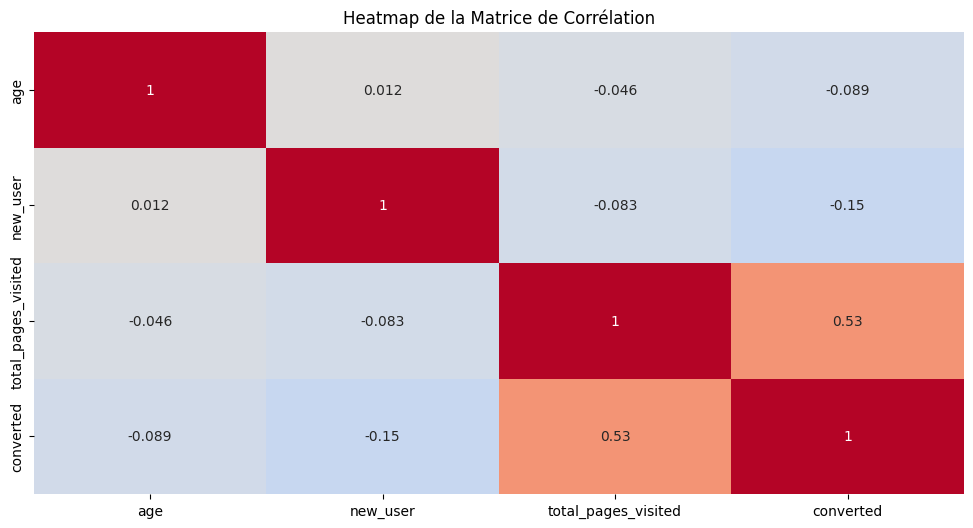

In [21]:
corr_mat = df1.corr(numeric_only=True)
plt.figure(figsize=(12, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1,cbar=False)
plt.title('Heatmap de la Matrice de Corrélation')
plt.show()

# Baseline Model

In [22]:
features_list = ["country","total_pages_visited","source"]
#features_list = ["age","country","total_pages_visited","source"]
target_variable = "converted"

X = df.loc[:, features_list]

Y = df.loc[:, target_variable]

print("...Done.")
print()

print("Y : ")
print(Y.head())
print()
print("X :")
print(X.head())

...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  total_pages_visited  source
0    China                    2  Direct
1       UK                    3     Ads
2  Germany                   14     Seo
3       US                    3     Seo
4       US                    3  Direct


In [23]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

In [24]:
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print("...Done.")
print()

...Done.



In [26]:
numeric_features=["total_pages_visited"]
categorical_features=["country","source"]

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [28]:
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print("...Done.")
print(
    X_train[0:5]
)
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(
    X_test
)
print("...Done.")
print(
    X_test[0:5, :]
)
print()

print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
       country  total_pages_visited source
162123      US                    4    Ads
27065    China                    3    Ads
70329       US                    3    Seo
138712      US                    8    Seo
104858      UK                    3    Ads
...Done.
[[-0.2618471   0.          0.          1.          0.          0.        ]
 [-0.56090876  0.          0.          0.          0.          0.        ]
 [-0.56090876  0.          0.          1.          0.          1.        ]
 [ 0.93439955  0.          0.          1.          0.          1.        ]
 [-0.56090876  0.          1.          0.          0.          0.        ]]

Encoding labels...
162123    0
27065     0
70329     0
138712    0
104858    0
Name: converted, dtype: int64
...Done
[0 0 0 0 0]
Performing preprocessings on test set...
       country  total_pages_visited  source
249036      US                    4     Seo
135422      UK                    5     Seo
242216   Chi

In [29]:
print("Train model...")
classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [30]:
print("Predictions on training set...")
Y_train_pred = classifier_lr.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

print("Probabilities on training set...")
Y_train_proba = classifier_lr.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[9.99125019e-01 8.74981059e-04]
 [9.99981832e-01 1.81680143e-05]
 [9.99598958e-01 4.01042206e-04]
 ...
 [9.99631151e-01 3.68849013e-04]
 [9.98175036e-01 1.82496357e-03]
 [9.99144275e-01 8.55724754e-04]]



In [31]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier_lr.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [33]:
# Calcul des métriques
metrics = {
    "Metric": ["Accuracy", "Recall", "Precision", "F1-Score"],
    "Train Set": [
        accuracy_score(Y_train, Y_train_pred),
        recall_score(Y_train, Y_train_pred),
        precision_score(Y_train, Y_train_pred),
        f1_score(Y_train, Y_train_pred)
    ],
    "Test Set": [
        accuracy_score(Y_test, Y_test_pred),
        recall_score(Y_test, Y_test_pred),
        precision_score(Y_test, Y_test_pred),
        f1_score(Y_test, Y_test_pred)
    ]
}

# Création du DataFrame
metrics_df = pd.DataFrame(metrics)

# Affichage du DataFrame
display(metrics_df)

,Metric,Train Set,Test Set
0,Accuracy,0.983950,0.984240
1,Recall,0.627996,0.628540
2,Precision,0.833394,0.842951
3,F1-Score,0.716260,0.720125


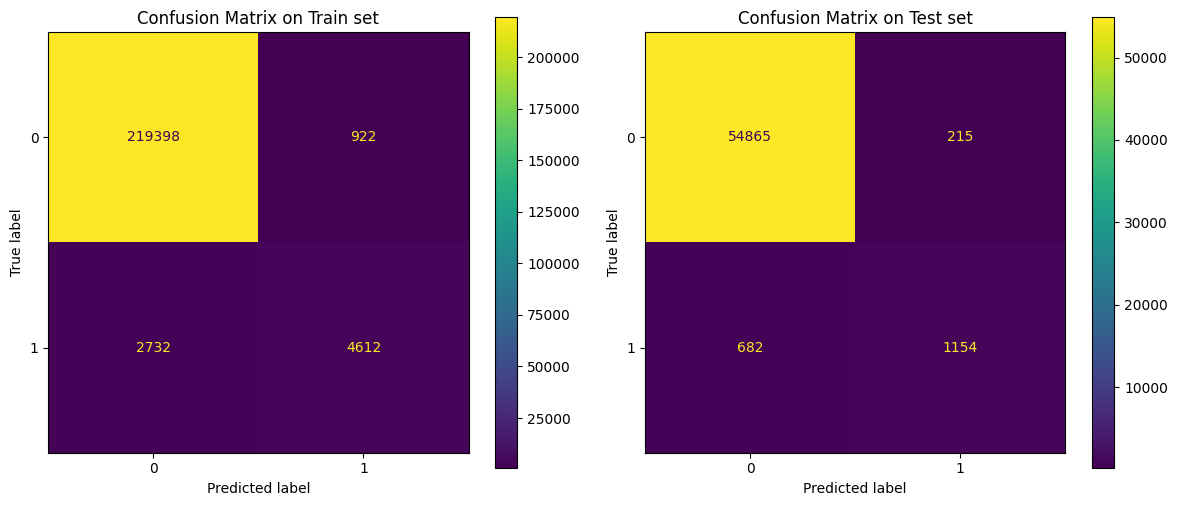

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Matrice de confusion pour l'ensemble d'entraînement
axs[0].set(title="Confusion Matrix on Train set")
ConfusionMatrixDisplay.from_estimator(
    classifier_lr, X_train, Y_train, ax=axs[0]
)

# Matrice de confusion pour l'ensemble de test
axs[1].set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(
    classifier_lr, X_test, Y_test, ax=axs[1]
)

# Affichage de la figure
plt.tight_layout()
plt.show()

In [35]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
coef = classifier_lr.coef_
imp_feat = pd.DataFrame(columns=col_names, data=coef)
display(imp_feat)

,total_pages_visited,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,2.535721,3.700556,3.466829,3.11706,-0.172939,-0.022273


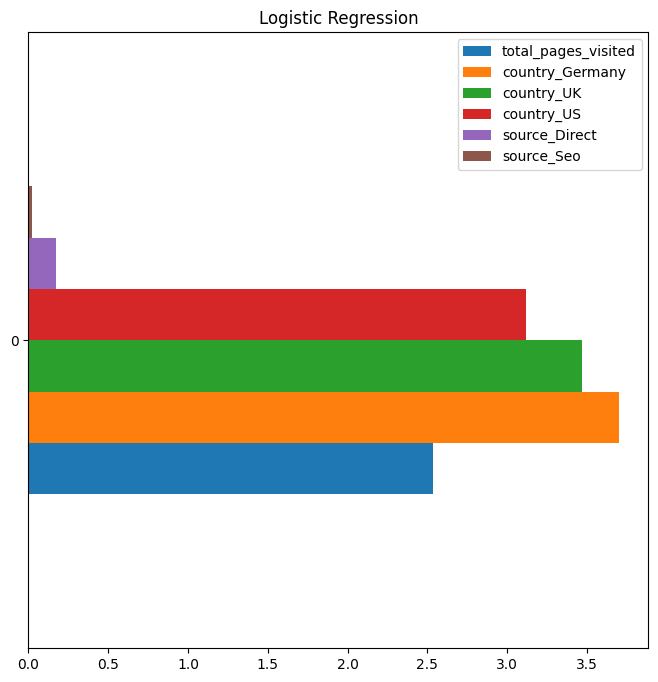

In [36]:
imp_feat.abs().plot(kind='barh', figsize=(8, 8))
plt.title('Logistic Regression')
plt.show()

XGBoost

In [37]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)
# Calcul du scale_pos_weight
y_train = pd.Series(Y_train)
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

In [38]:
features_list = ["age","country","total_pages_visited","source","new_user"]
target_variable = "converted"

X = df.loc[:, features_list]

Y = df.loc[:, target_variable]

print("...Done.")
print()

print("Y : ")
print(Y.head())
print()
print("X :")
print(X.head())

...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   age  country  total_pages_visited  source  new_user
0   22    China                    2  Direct         1
1   21       UK                    3     Ads         1
2   20  Germany                   14     Seo         0
3   23       US                    3     Seo         1
4   28       US                    3  Direct         1


In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print("...Done.")
print()

...Done.



In [40]:
numeric_features=["age","total_pages_visited","new_user"]
categorical_features=["country","source"]

In [41]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [42]:
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print("...Done.")
print(
    X_train[0:5]
)
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(
    X_test
)
print("...Done.")
print(
    X_test[0:5, :]
)
print()

print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
        age country  total_pages_visited source  new_user
162123   20      US                    4    Ads         1
27065    29   China                    3    Ads         1
70329    36      US                    3    Seo         0
138712   23      US                    8    Seo         1
104858   41      UK                    3    Ads         1


...Done.
[[-1.27650481 -0.2618471   0.6761303   0.          0.          1.
   0.          0.        ]
 [-0.18867057 -0.56090876  0.6761303   0.          0.          0.
   0.          0.        ]
 [ 0.65742272 -0.56090876 -1.47900486  0.          0.          1.
   0.          1.        ]
 [-0.9138934   0.93439955  0.6761303   0.          0.          1.
   0.          1.        ]
 [ 1.26177508 -0.56090876  0.6761303   0.          1.          0.
   0.          0.        ]]

Encoding labels...
162123    0
27065     0
70329     0
138712    0
104858    0
Name: converted, dtype: int64
...Done
[0 0 0 0 0]
Performing preprocessings on test set...
        age country  total_pages_visited  source  new_user
249036   32      US                    4     Seo         1
135422   30      UK                    5     Seo         1
242216   31   China                    5     Seo         1
209360   51      US                    5     Seo         0
1486     20      US                    3  Direct         1


In [43]:
from xgboost import XGBClassifier

In [45]:
# # Perform grid search
# print("Grid search...")
# xgboost = XGBClassifier()

# # Grid of values to be tested
# params = {
#     "max_depth": [2,10,20],  # exactly the same role as in scikit-learn
#     "min_child_weight": [2,4,8],  # effect is more or less similar to min_samples_leaf and min_samples_split
#     "n_estimators": [20,60,100],  # exactly the same role as in scikit-learn
#     #'scale_pos_weight': [ratio],
#     #regularisation alpha

#     #'reg_alpha': [0, 0.01, 0.1, 0.5,1],
#     #regularisation lambda
#     'reg_lambda': [0.01,0.5,2],
# }
# print(params)
# stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# gridsearch = GridSearchCV(
#     xgboost, param_grid=params, cv=stratified_kfold
# )  # cv : the number of folds to be used for CV
# gridsearch.fit(X_train, Y_train)
# print("...Done.")
# print("Best hyperparameters : ", gridsearch.best_params_)
# print("Best validation accuracy : ", gridsearch.best_score_)
# print()
# print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
# print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

In [46]:
classifier_XGB = XGBClassifier(max_depth= 2, min_child_weight= 8, n_estimators = 100, reg_lambda=2)
print("Fit model...")
classifier_XGB.fit(X_train,Y_train)
Y_train_pred = classifier_XGB.predict(X_train)
Y_test_pred = classifier_XGB.predict(X_test)

Fit model...


In [47]:
# Calcul des métriques
metrics = {
    "Metric": ["Accuracy", "Recall", "Precision", "F1-Score"],
    "Train Set": [
        accuracy_score(Y_train, Y_train_pred),
        recall_score(Y_train, Y_train_pred),
        precision_score(Y_train, Y_train_pred),
        f1_score(Y_train, Y_train_pred)
    ],
    "Test Set": [
        accuracy_score(Y_test, Y_test_pred),
        recall_score(Y_test, Y_test_pred),
        precision_score(Y_test, Y_test_pred),
        f1_score(Y_test, Y_test_pred)
    ]
}

# Création du DataFrame
metrics_df = pd.DataFrame(metrics)

# Affichage du DataFrame
display(metrics_df)

,Metric,Train Set,Test Set
0,Accuracy,0.986159,0.986260
1,Recall,0.691721,0.692810
2,Precision,0.851349,0.853691
3,F1-Score,0.763278,0.764883


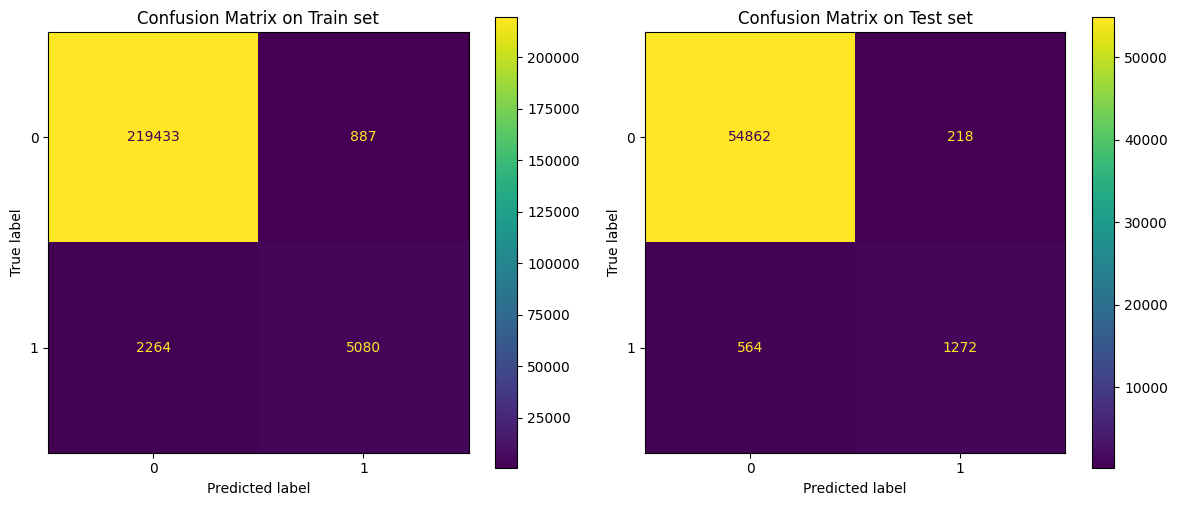

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Matrice de confusion pour l'ensemble d'entraînement
axs[0].set(title="Confusion Matrix on Train set")
ConfusionMatrixDisplay.from_estimator(
    classifier_XGB, X_train, Y_train, ax=axs[0]
)

# Matrice de confusion pour l'ensemble de test
axs[1].set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(
    classifier_XGB, X_test, Y_test, ax=axs[1]
)

# Affichage de la figure
plt.tight_layout()
plt.show()

In [49]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())

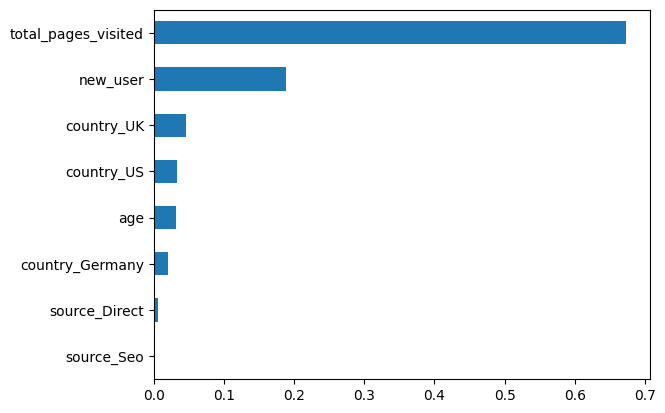

In [50]:
feat_import = pd.Series(classifier_XGB.feature_importances_, index=col_names)
feat_import.sort_values().plot(kind='barh')
plt.show()

In [51]:
# Concatiner X et Y
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier_XGB.fit(X,Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)
features_list = ['total_pages_visited','age','new_user','country','source']
X_without_labels = data_without_labels.loc[:, features_list]
print("...Done")
print(X_without_labels)

Prediction set (without labels) : (31620, 5)
...Done
       total_pages_visited  age  new_user  country  source
0                       16   28         0       UK     Seo
1                        5   22         1       UK  Direct
2                        1   32         1    China     Seo
3                        6   32         1       US     Ads
4                        3   25         0    China     Seo
...                    ...  ...       ...      ...     ...
31615                    3   25         1  Germany     Seo
31616                    7   36         1       US     Ads
31617                    5   33         1       UK     Seo
31618                   14   25         1       UK     Seo
31619                    2   22         1       US     Seo

[31620 rows x 5 columns]


In [53]:
X_without_labels = data_without_labels.loc[:, features_list]
print(data_without_labels.head())
# same preprocessing on X_without_labels
X_without_labels = preprocessor.transform(X_without_labels)

  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [54]:
data = {'converted': classifier_XGB.predict(X_without_labels)}
Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_seddik-XGBoost.csv', index=False)